In [1]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, plasma
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimage
from scipy import stats
import seaborn as sns
import math
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

In [2]:
def UTC2CST(data):
    '''
    说明：将世界时（UTC）转换成北京时间（CST）
    :param data: 世界时数据 输入数据为列表 格式为：['1940-01-01T00:00:00']  注：如果'1940-01-01 00:00:00' 则 datetime.datetime.strptime('1940-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
    :return: 相应的北京时数据列表
    '''
    dataCST = []
    for id1, dataEach in enumerate(data):
        dataEachUtcTime = datetime.datetime.strptime(dataEach, '%Y-%m-%dT%H:%M:%S')
        utc_timezone = pytz.timezone('UTC')
        dataEachUtcTime = utc_timezone.localize(dataEachUtcTime)
        beijing_timezone = pytz.timezone('Asia/Shanghai')
        beijing_time = dataEachUtcTime.astimezone(beijing_timezone)
        dataCST.append(beijing_time)
    return dataCST

def return_time(years,months,days,hours,minutes):
    t1 = [str(int(years[x]))+'-'+str(int(months[x]))+'-'+str(int(days[x]))+'T'+str(int(hours[x]))+':'+str(int(minutes[x]))+':00' for x in range(len(years))]
    return t1

In [3]:
timelist = np.load('/home/penny/works/psd/inputs/radar_timelist.npy')

### Calculate Gamma distribution parameter with 3,4,6 Moment

In [4]:
#32速度（m/s）
D = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,
              1.1875,1.375,1.625,1.875,2.125,2.375,2.75,3.25,3.75,4.25,4.75,5.5,
              6.5,7.5,8.5,9.5,11,13,15,17,19,21.5,24.5])
#32直径（mm）
V = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.1,1.3,1.5,1.7,
              1.9,2.2,2.6,3,3.4,3.8,4.4,5.2,6,6.8,7.6,8.8,10.4,12,13.6,15.2,
              17.6,20.8])

D[8:24] = (1.075 - 0.075*D[8:24])*D[8:24]
D[24:] = D[24:]*0.7

#采样面积不固定的
A = np.zeros((32,1),dtype='float')
#32直径通道间隔
detaD = np.zeros((32,1),dtype='float')
#通道间隔（mm）
detaD[0]=D[1]-D[0]
for i in range(1,32):
    detaD[i]=D[i]-D[i-1]
#采样面积  m**2 
for i in range(32):
     A[i,0] = 0.18*(0.03-(D[i]/1000))
#month_list = ['01','03','05','07','08','10','12']

In [5]:
delta_h = 1+3.68*10**-5*3465 + 1.71*10**-9*3465**2
Vt = delta_h*(9.65-10.3/(np.exp(0.6*D)))

In [6]:
#bac_list = np.load('./inputs/bac_list_32_mie_cla_2.npy')

In [7]:
# t [2,31]
t_grid = np.arange(2,32,1)
bac_list_t = np.load('./inputs/bac_list_32_mie_cla_2_t.npy')
ext_list_t = np.load('./inputs/ext_list_32_mie_cla_2_t.npy')

In [15]:
N0     = np.load('./results/3N0_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
#miu    = np.load('./results/miu_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
sigma  = np.load('./results/3sigma_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
Z_list = np.load('./results/3Z_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
R_list = np.load('./results/3R_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
Dm_list = np.load('./results/3dm_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
Wc_list = np.load('./results/3wc_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)

In [16]:
N0     = np.array([math.log10(x) for x in N0],dtype = np.float64)

In [18]:
Z10_20_idx = np.where((Z_list>=-10) & (Z_list<10))[0]
Z20_25_idx = np.where((Z_list>=10) & (Z_list<20))[0]
Z25_30_idx = np.where((Z_list>=20) & (Z_list<30))[0]
Z30_40_idx = np.where((Z_list>=30) & (Z_list<45))[0]

idx_list = [Z10_20_idx,Z20_25_idx,Z25_30_idx,Z30_40_idx]

In [19]:
legend_list= ['[-10,10)','[10,20)','[20,30)','[30,45)']

In [20]:
label_list = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)']
legend_list= ['Z in [-10,10)','Z in [10,20)','Z in [20,30)','Z in [30,40)']

In [21]:
Z_list.shape[0]

113775

/tmp/ipykernel_9781/1329778301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='data', y='leibie', data=df,width = 0.5,linewidth=2, palette="Set2")


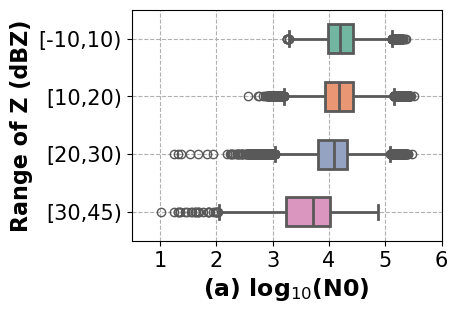

In [30]:
df = pd.DataFrame(np.zeros((Z_list.shape[0],2)), columns = ['data','leibie'])
df['data'] = list(N0[idx_list[0]])+list(N0[idx_list[1]])+list(N0[idx_list[2]])+list(N0[idx_list[3]])
df['leibie'] = list(np.repeat('[-10,10)',len(N0[idx_list[0]])))+list(np.repeat('[10,20)',len(N0[idx_list[1]])))+list(np.repeat('[20,30)',len(N0[idx_list[2]])))+list(np.repeat('[30,45)',len(N0[idx_list[3]])))

f  = plt.figure(figsize = (4,3))
sns.boxplot(x='data', y='leibie', data=df,width = 0.5,linewidth=2, palette="Set2")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlim(0.5,6)
plt.grid(True,linestyle = '--')
plt.xlabel('(a) log$_{10}$(N0)',size  =17,fontweight='bold')
plt.ylabel('Range of Z (dBZ)',size = 16,fontweight='bold')
plt.savefig('/home/penny/works/psd/results/wok05/N0_sa.png',bbox_inches = 'tight')

/tmp/ipykernel_9781/2206104468.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='data', y='leibie', data=df,width = 0.5,linewidth=2, palette="Set2")


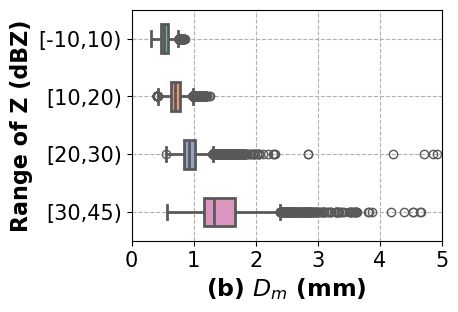

In [29]:
df = pd.DataFrame(np.zeros((Z_list.shape[0],2)), columns = ['data','leibie'])
df['data'] = list(sigma[idx_list[0]])+list(sigma[idx_list[1]])+list(sigma[idx_list[2]])+list(sigma[idx_list[3]])
df['leibie'] = list(np.repeat('[-10,10)',len(sigma[idx_list[0]])))+list(np.repeat('[10,20)',len(sigma[idx_list[1]])))+list(np.repeat('[20,30)',len(sigma[idx_list[2]])))+list(np.repeat('[30,45)',len(sigma[idx_list[3]])))

f  = plt.figure(figsize = (4,3))
sns.boxplot(x='data', y='leibie', data=df,width = 0.5,linewidth=2, palette="Set2")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlim(0,5)
plt.grid(True,linestyle = '--')
plt.xlabel('(b) $D_m$ (mm)',size  =17,fontweight='bold')
plt.ylabel('Range of Z (dBZ)',size = 16,fontweight='bold')
plt.savefig('/home/penny/works/psd/results/wok05/dm_sa.png',bbox_inches = 'tight')

In [23]:
np.mean(sigma)

0.7676056479300982

In [26]:
np.max(sigma)

13.038423578123664